In [1]:
import numpy as np
import tensorflow as tf
import c3po.component as component
import c3po.control as control
import c3po.hamiltonians as hamiltonians
import c3po.envelopes as envelopes
import c3po.generator as generator
from c3po.component import Quantity as Qty
from c3po.model import Model as Mdl
from c3po.simulator import Simulator as Sim
from c3po.experiment import Experiment as Exp
import matplotlib.pyplot as plt

### Create Model, Gates and Generator

In [2]:
freq = 25e9 # I DIDN'T WANT TO DEAL WITH THE 2pi
time = 10.3781e-9 # time x freq shouldn't be an integer otherwise FR is not needed

a simple 2-level system, with x-drive

In [3]:
q1 = component.Qubit(
    name="Q1",
    desc="Qubit 1",
    comment="The one and only qubit in this chip",
    freq=Qty(
        value=freq,
        min=21e9,
        max=33e9,
        unit='Hz 2pi'
    ),
    hilbert_dim=2
)
drive = component.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive
)
phys_components = [q1]
line_components = [drive]
model = Mdl(phys_components, line_components)

In [4]:
gauss_params = {
    'amp': Qty(
        value=0.5 * np.pi,
        min=1,
        max=3
    ),
    't_final': Qty(
        value=10e-9,
        min=5e-9,
        max=15e-9,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min=-1 * np.pi/2,
        max=1 * np.pi/2,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=0.0,
        min=-5e9,
        max=5e9,
        unit='Hz 2pi'
    )
}
gauss_env = control.Envelope(
    name="gauss",
    desc="Gaussian comp 1 of signal 1",
    params=gauss_params,
    shape=envelopes.gaussian
)
carrier_parameters = {
    'freq': Qty(
            value=freq,
            min=21e9,
            max=33e9
    )
}
carr = control.Carrier(
    name="carrier",
    desc="Frequency of the local oscillator",
    params=carrier_parameters
)
X90p = control.Instruction(
    name="X90p",
    t_start=0.0,
    t_end=10e-9,
    channels=["d1"]
)
X90p.add_component(gauss_env, "d1")
X90p.add_component(carr, "d1")
gates = control.GateSet()
gates.add_instruction(X90p)

In [5]:
sim_res = 300e9
awg_res = 300e9
lo = generator.LO(name='lo', resolution=sim_res)
awg = generator.AWG(name='awg', resolution=awg_res, logdir='')
mixer = generator.Mixer(name='mixer')
v_to_hz = generator.Volts_to_Hertz(
    name='v_to_hz', 
    V_to_Hz=Qty(
        value=1,
        min=0.5,
        max=3,
        unit='rad/V'
    )
)
dig_to_an = generator.Digital_to_Analog(name="dac",resolution=sim_res)
devices = [lo, awg, mixer, v_to_hz, dig_to_an]
gen = generator.Generator(devices)

In [6]:
exp = Exp(model, gen)
sim = Sim(exp, gates)
sim.use_VZ = False

### 1st TEST: Simple X90p rotation and VZ/FR working

the perfect X90p gate, it's a rotation around the X axis by 90 degrees

In [7]:
import c3po
c3po.qt_utils.X90p

array([[0.70710678+0.j        , 0.        -0.70710678j],
       [0.        -0.70710678j, 0.70710678+0.j        ]])

now the dynamics withouth doing the frame rotation at the end

In [8]:
sim.get_gates()['X90p']

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid value for "node": expected "ast.AST", got "<class 'NoneType'>"; to visit lists of nodes, use "visit_block" instead
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

<tf.Tensor: shape=(2, 2), dtype=complex128, numpy=
array([[ 7.07270250e-01+0.00200946j, -4.51210206e-07-0.70694042j],
       [ 6.86105593e-01-0.17036394j,  1.72394095e-01+0.68594134j]])>

notice how the second row has been rotated

In [9]:
c3po.qt_utils.X90p

array([[0.70710678+0.j        , 0.        -0.70710678j],
       [0.        -0.70710678j, 0.70710678+0.j        ]])

In [10]:
sim.use_VZ = True
sim.get_gates()['X90p']

<tf.Tensor: shape=(2, 2), dtype=complex128, numpy=
array([[ 7.07270250e-01+0.00200946j, -4.51210206e-07-0.70694042j],
       [ 4.51066871e-07-0.70694042j,  7.07270250e-01-0.00200946j]])>

instead now the gate is almost perfectly an X90p, not sure where the error is coming from (freq shift during drive?). **WHY THIS DISCREPANCY??**

we can also look at the drive shapes

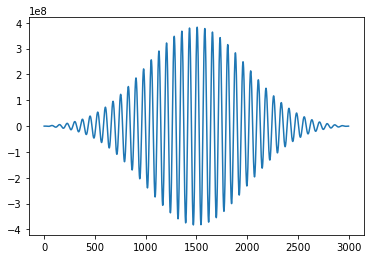

In [11]:
plt.plot(gen.devices['mixer'].signal)

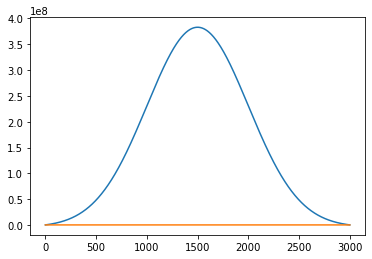

In [12]:
plt.plot(gen.devices['awg'].get_I())
plt.plot(gen.devices['awg'].get_Q())

and at the dynamics

In [13]:
psi_init = tf.constant(c3po.qt_utils.basis(2,0))
psi_init

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[1.],
       [0.]])>

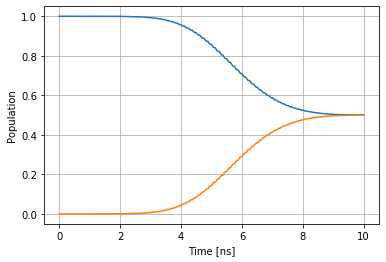

In [14]:
sim.plot_dynamics(psi_init=psi_init, seq=['X90p'])

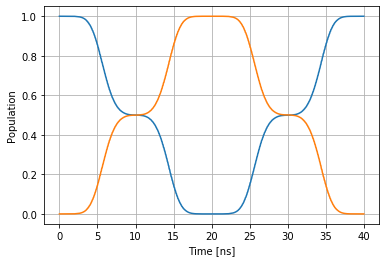

In [15]:
sim.plot_dynamics(psi_init=psi_init, seq=['X90p','X90p','X90p','X90p'])

### 2nd TEST: XY angle

In [16]:
import copy

In [17]:
Y90p = copy.deepcopy(X90p)
Y90p.name = "Y90p"
Y90p.comps['d1']['gauss'].params['xy_angle'] = Qty(
    value=np.pi / 2,
    min=0,
    max=2 * np.pi/2,
    unit='rad'
)
gates.add_instruction(Y90p)

In [18]:
c3po.qt_utils.Y90p

array([[ 0.70710678+0.j, -0.70710678+0.j],
       [ 0.70710678+0.j,  0.70710678+0.j]])

In [19]:
sim.get_gates()['Y90p']

<tf.Tensor: shape=(2, 2), dtype=complex128, numpy=
array([[ 0.70727003+2.00842858e-03j, -0.70694064-4.51208629e-07j],
       [ 0.70694064-4.51351965e-07j,  0.70727003-2.00842872e-03j]])>

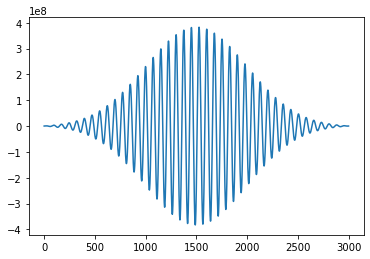

In [20]:
plt.plot(gen.devices['mixer'].signal)

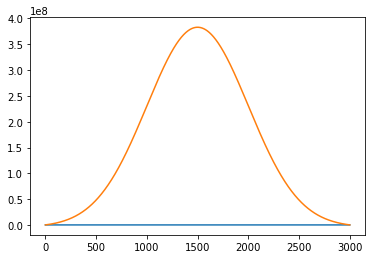

In [21]:
plt.plot(gen.devices['awg'].get_I())
plt.plot(gen.devices['awg'].get_Q())

and at the dynamics

In [22]:
psi_init

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[1.],
       [0.]])>

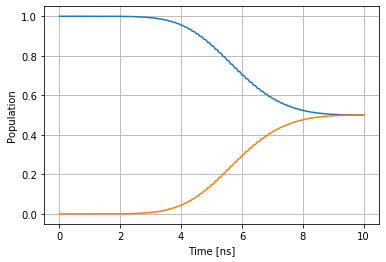

In [23]:
sim.plot_dynamics(psi_init=psi_init, seq=['Y90p'])

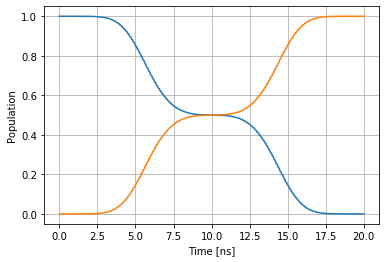

In [24]:
sim.plot_dynamics(psi_init=psi_init, seq=['Y90p', 'Y90p'])

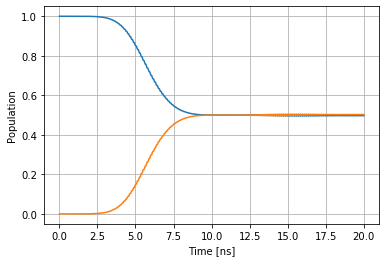

In [25]:
sim.plot_dynamics(psi_init=psi_init, seq=['Y90p', 'X90p'])

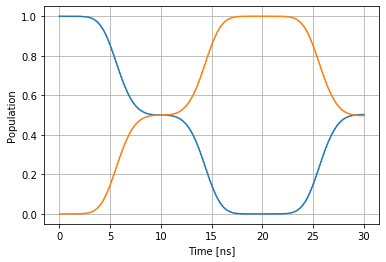

In [26]:
sim.plot_dynamics(psi_init=psi_init, seq=['X90p', 'X90p', 'Y90p'])

### 3nd TEST: Freq Offset

In [27]:
freq_offset = 3e9
freq+freq_offset

28000000000.0

In [28]:
q1.params['freq'].set_value(freq+freq_offset)
q1.params['freq'].get_value()
model.update_model()

In [29]:
model.subsystems['Q1'].params['freq'].get_value()

<tf.Tensor: shape=(), dtype=float64, numpy=28000000000.0>

quick check, these should be the same

In [30]:
gates.instructions['X90p'].comps['d1']['gauss'].params['freq_offset'].set_value(freq_offset)
gates.instructions['Y90p'].comps['d1']['gauss'].params['freq_offset'].set_value(freq_offset)
gates.instructions['X90p'].comps['d1']['gauss'].params['freq_offset'].get_value()

<tf.Tensor: shape=(), dtype=float64, numpy=3000000000.0>

In [31]:
Udict = sim.get_gates()

In [32]:
Udict['X90p']

<tf.Tensor: shape=(2, 2), dtype=complex128, numpy=
array([[7.07311951e-01+0.0017939j , 6.29764789e-07-0.70689928j],
       [6.98438742e-01-0.10904086j, 1.10876326e-01+0.69856986j]])>

notice how here there is a Z rotation unaccounted for. That is because we changed the qubit frequency but the local oscillator is still 3e9 away, to account for it we would need to add a phase to the awg values

In [33]:
c3po.qt_utils.X90p

array([[0.70710678+0.j        , 0.        -0.70710678j],
       [0.        -0.70710678j, 0.70710678+0.j        ]])

In [34]:
Udict['Y90p']

<tf.Tensor: shape=(2, 2), dtype=complex128, numpy=
array([[ 0.70730896+1.79506187e-03j, -0.70690227+6.29763291e-07j],
       [ 0.10904008+6.98441894e-01j,  0.11087701+6.98566726e-01j]])>

In [35]:
c3po.qt_utils.Y90p

array([[ 0.70710678+0.j, -0.70710678+0.j],
       [ 0.70710678+0.j,  0.70710678+0.j]])

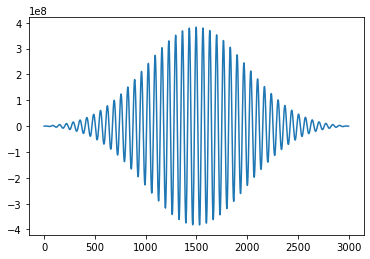

In [36]:
plt.plot(gen.devices['mixer'].signal)

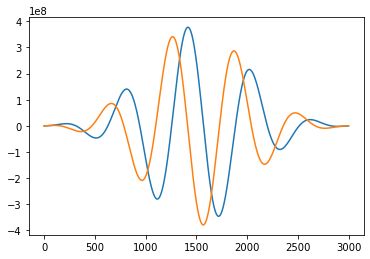

In [37]:
plt.plot(gen.devices['awg'].get_I())
plt.plot(gen.devices['awg'].get_Q())

and at the dynamics

In [38]:
psi_init

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[1.],
       [0.]])>

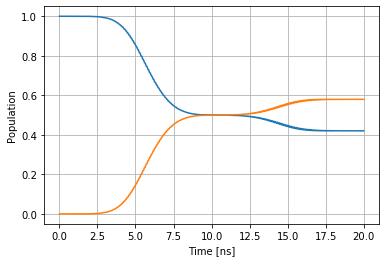

In [39]:
sim.plot_dynamics(psi_init=psi_init, seq=['Y90p', 'Y90p'])

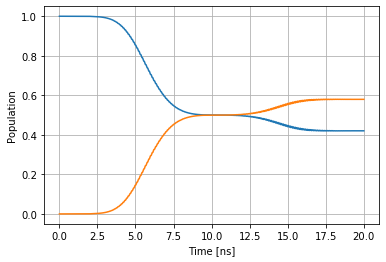

In [40]:
sim.plot_dynamics(psi_init=psi_init, seq=['X90p', 'X90p'])

REALLY WEIRD BEHAVIOUR FOLLOWS

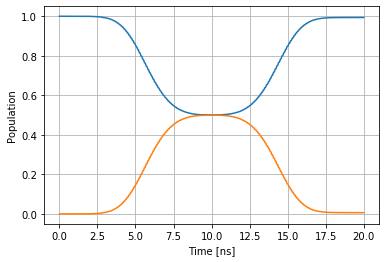

In [41]:
sim.plot_dynamics(psi_init=psi_init, seq=['Y90p', 'X90p'])

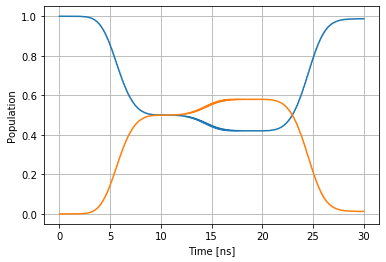

In [42]:
sim.plot_dynamics(psi_init=psi_init, seq=['X90p', 'X90p', 'X90p'])

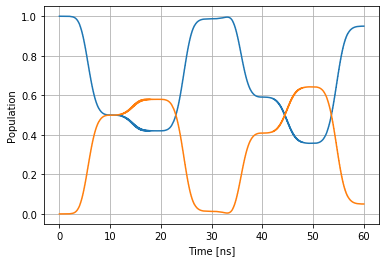

In [43]:
sim.plot_dynamics(psi_init=psi_init, seq=['X90p', 'X90p', 'X90p', 'X90p', 'X90p', 'X90p'])

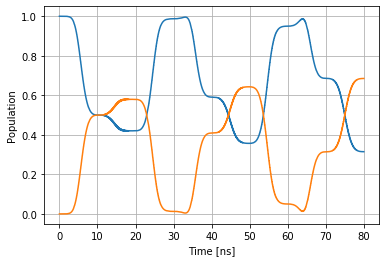

In [44]:
sim.plot_dynamics(psi_init=psi_init, seq=['X90p', 'X90p', 'X90p', 'X90p', 'X90p', 'X90p', 'X90p', 'X90p'])